### Enoncé de problématique :
La fonderie est un processus de fabrication dans lequel un matériau liquide est généralement versé dans un moule, qui contient une cavité creuse de la forme souhaitée, puis laissé durcir.

Un défaut de moulage est une irrégularité indésirable dans un processus de moulage de métal.
Il existe de nombreux types de défauts de moulage tels que les trous de soufflage, les trous d'épingle, les bavures, les défauts de rétraction, les défauts de matériau de moule, les défauts de métal de coulée, les défauts métallurgiques, etc

L'objectif de développement d'un modèle de classification d'images est de faciliter la procédure d'identification de ces défauts et de diminuer le taux des non conformités..

In [ ]:
!pip install pandas
!pip install tensorflow

In [ ]:
!pip install seaborn

In [ ]:
!pip install -U scikit-learn

In [4]:
!pip install opencv-python

^C


## Etape 1 : Importer les bibliothèques nécessaires

In [23]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import cv2


## Etape 2 : Importer Dataset

In [24]:
data_dir = 'train' #we need to loop into it

In [9]:
image_ext = ['jpeg', 'jpg', 'bmp', 'png'] #List

In [10]:
os.listdir(data_dir)

['def_front', 'ok_front']

In [ ]:
os.listdir(os.path.join(data_dir, 'def_front'))

In [12]:
for image_class in os.listdir(data_dir):
    print(image_class)

def_front
ok_front


In [ ]:
for image_class in os.listdir(data_dir):
    print(image_class)
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image)

In [16]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print('image not in extention list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [19]:
# Use a dataset API of tensorflow : Data pipeline/builds the labels and the classes and does some preprocessing
data_train = tf.keras.utils.image_dataset_from_directory('train')

Found 6633 files belonging to 2 classes.


In [121]:
# we need to grab the data we want
data_iterator = data_train.as_numpy_iterator()
#allows to access the generator => use the index method on the data

In [122]:
data_iterator #loop through the data

In [123]:
batch = data_iterator.next() #grab one batch

In [ ]:
batch

In [16]:
len(batch) #images + Labels

2

In [17]:
#Images represented as numpy arrays
batch[0].shape
# batch size=32 default from the keras utils, 

(32, 256, 256, 3)

In [18]:
batch[1] #represents the labels

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

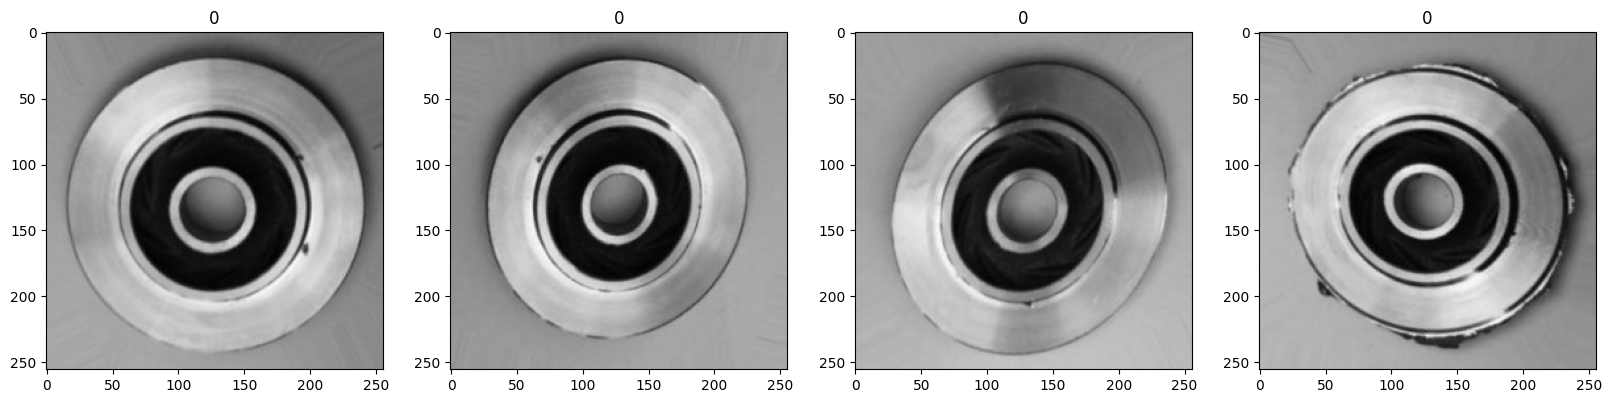

In [19]:
# Which class is given to which image
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [20]:
# Class 0 : def
# Class 1 : OK

## Etape 3 : Pré-traitement des données : Normalisation

In [ ]:
data_scale = data_train.map(lambda x, y: (x/255, y))

In [ ]:
data_scale.as_numpy_iterator().next()

In [134]:
data_scale.as_numpy_iterator().next()[0].max()

0.9995883

In [86]:
data_scale.as_numpy_iterator().next()[0].min()

0.0

In [112]:
data_train = data_scale.as_numpy_iterator()

In [113]:
batch_train = data_train.next()

## Etape 3 : Création de model

In [22]:
model = Sequential() # déclaration de modèles

In [23]:
#Create the model
model.add(Conv2D(32, (3,3), 2, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), 2, activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(16, (3,3), 2, activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [25]:
# compile the model
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          9232      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 16)          0

## Etape 4 : Diviser les données en un dataset d'entrainement et validation

In [27]:
# Assuming 'data_scale' is a TensorFlow Dataset
train_size = int(len(data_scale)*.7)
train_data = data_scale.take(train_size)
val_data = data_scale.skip(train_size)

## Etape 5 : Entrainement du model

In [28]:
fit_model = model.fit(train_data, epochs=20, validation_data=val_data, callbacks =early_stopping)

Epoch 1/20
145/145 [==============================] - 92s 601ms/step - loss: 0.6013 - accuracy: 0.6653 - val_loss: 0.4565 - val_accuracy: 0.7732
Epoch 2/20
145/145 [==============================] - 80s 550ms/step - loss: 0.4060 - accuracy: 0.8144 - val_loss: 0.3673 - val_accuracy: 0.8389
Epoch 3/20
145/145 [==============================] - 79s 545ms/step - loss: 0.2991 - accuracy: 0.8685 - val_loss: 0.2829 - val_accuracy: 0.8731
Epoch 4/20
145/145 [==============================] - 82s 559ms/step - loss: 0.2383 - accuracy: 0.9041 - val_loss: 0.2019 - val_accuracy: 0.9293
Epoch 5/20
145/145 [==============================] - 78s 533ms/step - loss: 0.1849 - accuracy: 0.9312 - val_loss: 0.1927 - val_accuracy: 0.9227
Epoch 6/20
145/145 [==============================] - 78s 537ms/step - loss: 0.1462 - accuracy: 0.9455 - val_loss: 0.1450 - val_accuracy: 0.9388
Epoch 7/20
145/145 [==============================] - 80s 546ms/step - loss: 0.1303 - accuracy: 0.9513 - val_loss: 0.1256 - val_ac

In [116]:
#Create the model
model.add(Conv2D(32, (3,3), 2, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), 2, activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

nd_model = model.fit(train_data, epochs=20, validation_data=val_data, callbacks =early_stopping)

Epoch 1/20
145/145 [==============================] - 98s 655ms/step - loss: 0.6569 - accuracy: 0.6308 - val_loss: 0.5821 - val_accuracy: 0.6638
Epoch 2/20
145/145 [==============================] - 91s 625ms/step - loss: 0.4034 - accuracy: 0.8166 - val_loss: 0.3115 - val_accuracy: 0.8635
Epoch 3/20
145/145 [==============================] - 87s 599ms/step - loss: 0.2470 - accuracy: 0.9000 - val_loss: 0.2096 - val_accuracy: 0.9117
Epoch 4/20
145/145 [==============================] - 87s 596ms/step - loss: 0.1591 - accuracy: 0.9448 - val_loss: 0.1196 - val_accuracy: 0.9614
Epoch 5/20
145/145 [==============================] - 115s 789ms/step - loss: 0.1019 - accuracy: 0.9688 - val_loss: 0.1943 - val_accuracy: 0.9177
Epoch 6/20
145/145 [==============================] - 90s 618ms/step - loss: 0.0724 - accuracy: 0.9817 - val_loss: 0.1427 - val_accuracy: 0.9528
Epoch 7/20
145/145 [==============================] - 87s 598ms/step - loss: 0.0692 - accuracy: 0.9797 - val_loss: 0.0721 - val_a

## Etape 5 : Evaluation des performances visuellment

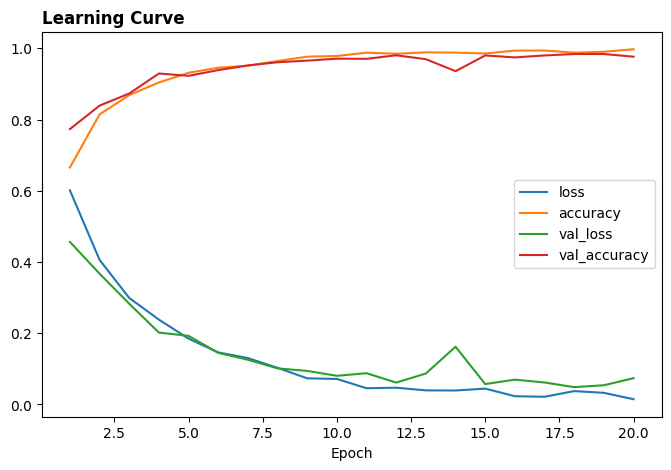

In [31]:
# Plot learning curve from model history
n_epochs=20
histo_dict = fit_model.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()


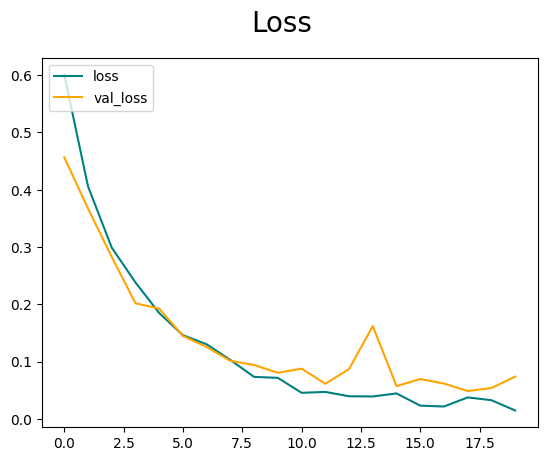

In [33]:
fig = plt.figure()
plt.plot(fit_model.history['loss'], color='teal',label='loss')
plt.plot(fit_model.history['val_loss'], color='orange',label='val_loss')
plt.legend(loc="upper left")
fig.suptitle('Loss', fontsize=20)
plt.show()

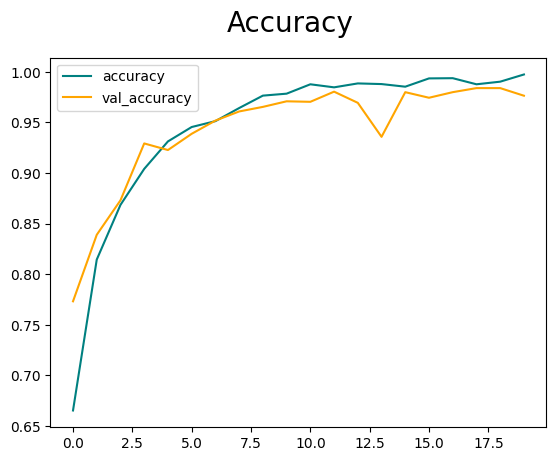

In [34]:
fig = plt.figure()
plt.plot(fit_model.history['accuracy'], color='teal',label='accuracy')
plt.plot(fit_model.history['val_accuracy'], color='orange',label='val_accuracy')
plt.legend(loc="upper left")
fig.suptitle('Accuracy', fontsize=20)
plt.show()

## Etape 6 : Faire des prédictions

In [35]:
test_dir = 'test'

In [36]:
os.listdir(test_dir)

['def_front', 'ok_front']

In [37]:
# Evaluation 
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for image_test in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, image_test)):
        image_path = os.path.join(test_dir, image_test, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print('image not in extention list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [114]:
data_test = tf.keras.utils.image_dataset_from_directory('test')

Found 715 files belonging to 2 classes.


In [117]:
batch_test =  data_test.as_numpy_iterator().next()

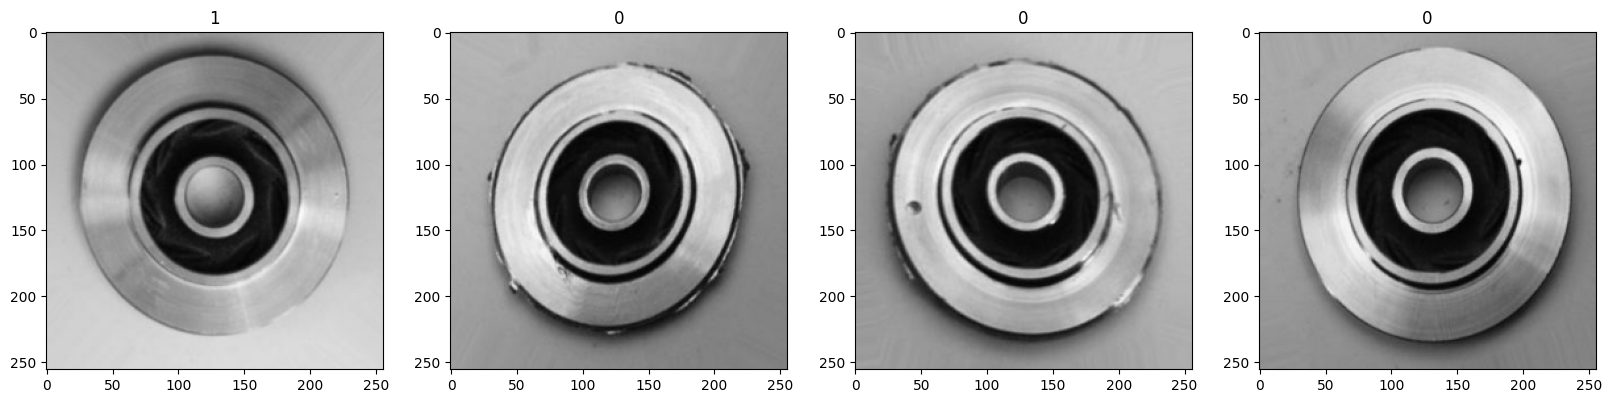

In [118]:
# Which class is given to which image
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_test[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_test[1][idx])

In [111]:
data_fin = data_test.map(lambda x, y: (x/255, y))

In [112]:
data_fin.as_numpy_iterator().next()[0].max()

0.99931496

In [43]:
test_size = int(len(data_fin)*1)
test_data = data_fin.take(test_size)

In [61]:
test_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [79]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 124ms/step


In [74]:
X.shape

(11, 256, 256, 3)

In [125]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision:0.9887217879295349, Recall:0.9813432693481445, Accuracy:0.9889807105064392


In [96]:
y_true = []
y_pred = []

for batch in test_data.as_numpy_iterator():
    X, y_batch = batch  # Use a different variable name to avoid overwriting the original 'y'
    yhat = model.predict(X)
    y_pred.extend(yhat)  # Accumulate predictions
    y_true.extend(y_batch)  

1/1 [==============================] - 0s 161ms/step


In [97]:
threshold = 0.5
yhat_binary = [1 if pred > threshold else 0 for pred in y_pred]

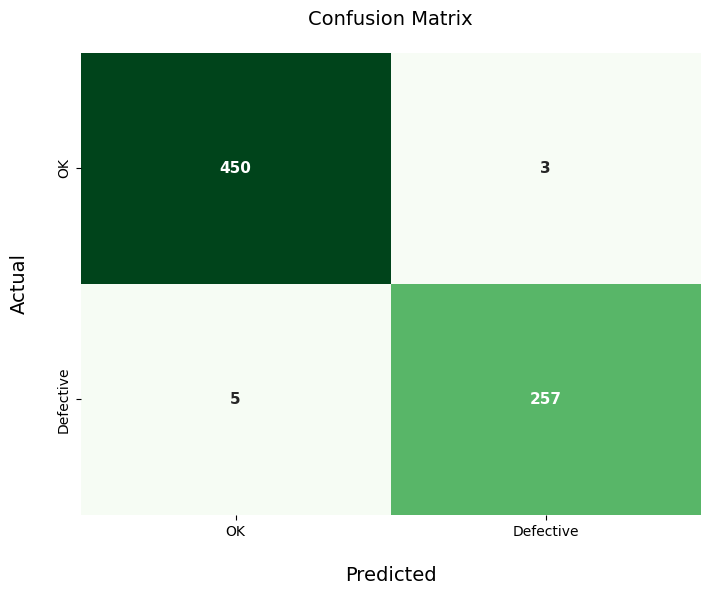

In [98]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_true,yhat_binary), annot=True,
                 annot_kws={'size':11, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Greens')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')

ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

In [99]:
print(classification_report(y_true,yhat_binary, digits=4))

              precision    recall  f1-score   support

           0     0.9890    0.9934    0.9912       453
           1     0.9885    0.9809    0.9847       262

    accuracy                         0.9888       715
   macro avg     0.9887    0.9871    0.9879       715
weighted avg     0.9888    0.9888    0.9888       715



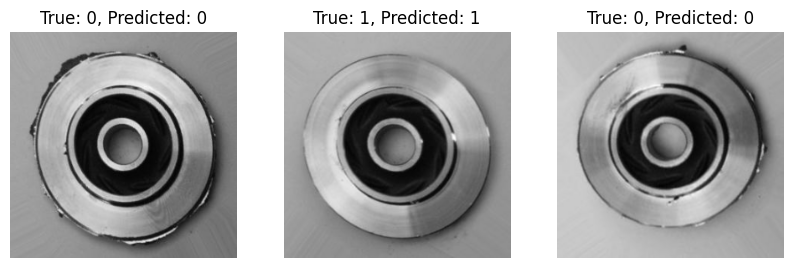

In [106]:
    # Display a few sample images along with their true and predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(3):  # Show the first 9 images in this batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        true_label = y_true[i]  # Assuming labels are in a tensor
        predicted_label = yhat_binary[i]  # Adjust as per your prediction format
        plt.title(f'True: {true_label}, Predicted: {predicted_label}')
        plt.axis('off')

plt.show()